# <center> DATA OBTENTION & PREPROCESSING <center>

This notebook is a guide to obtain and preprocess the data used to train and test CLASTER. 


### Before we start ...

A) It would be highly recommendable to create an environment for this project. EIR will need python >= 3.11. If you have anaconda, it can be done as follows from the terminal:

```bash
conda create -n claster_env python=3.11 -y #Create environment conda create -p ./claster_env python=3.11 -y
conda activate claster_env #Activate it
pip install ipykernel #Install ipykernel to run notebook
```


> ⚠️ Warning ⚠️
>
> If you created a specific environment, make sure to have it activated.
>
> In VS code we can simply choose the environment we want in the top right icon.





B) We will first install a number of dependencies required to follow the pipeline. 


In [ ]:
# Install pyBigWig
! pip install pyBigWig wget pandas cooler matplotlib imageio

# 1. Data obtention

**Import libraries**

In [1]:
import os 
from pathlib import Path
import pandas as pd
import numpy as np
import pyBigWig
import matplotlib.pyplot as plt
import wget
from scipy.ndimage import gaussian_filter1d, rotate
import cooler
import logging

**Functions**

In [2]:
def download_files(links, destination_folder):
    for name,link in links.items():
        try:
            # Ensure the destination folder exists
            if not os.path.exists(destination_folder):
                os.makedirs(destination_folder)

            # Specify the output path for the downloaded file
            output_path = os.path.join(destination_folder, name)

            # Download the file to the specified destination folder
            wget.download(link, out=output_path)
            print(f"\nSuccessfully downloaded {name} to {destination_folder}")
        except Exception as e:
            print(f"\nFailed to download {link} because : {e}")



**Gene annotations** 

Release M25 (GRCm38.p6) from GENCODE**


In [ ]:

links = {"Gene_annotations.gtf.gz":"https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.annotation.gtf.gz"}
savepath = "../annotations/"
download_files(links, savepath)

! gunzip ../annotations/Gene_annotations.gtf.gz

# Create a file with annotations that correspond only to genes
! awk '$3 == "gene"' ../annotations/Gene_annotations.gtf > ../annotations/Filtered_gene_annotations.gtf

# Further filter the number of fields/columns required

file = Path("../annotations/Filtered_gene_annotations.gtf")
outfile = Path("../annotations/Final_gene_annotations.tsv")
gene_annotations = pd.read_csv(file, sep="\t", header=None)

ids = []
names = []

final_df = pd.DataFrame(columns=["ID","chr","Start","End","Strand","Name","type"]).set_index("ID")
for (chrom, _, _, start, end, _, strand, _, features) in gene_annotations.values:
    splitline =  features.split(";")
    id = splitline[0].split(" ")[1]
    gene_type = splitline[1].split(" ")[2]
    name = splitline[2].split(" ")[2]

    if gene_type == '"protein_coding"' and chrom !='chrM' : # or gene_type == '"lincRNA"':
        final_df.loc[id[1:-1]] = [chrom,start,end,strand,name[1:-1], gene_type[1:-1]]

final_df.to_csv(outfile, sep='\t')


**Enhancer annotations**

Coordinates for proximal Enhancer Like Signatures (pELS) and distal Enhancer Like Signatures (dELS) were obtained from Supplementary Table 11 in the paper: 
- https://doi.org/10.1038/s41586-020-2493-4

Download link:
- https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-020-2493-4/MediaObjects/41586_2020_2493_MOESM13_ESM.txt

Once downloaded, you should move the file to the annotations folder to proceed. E.g.:
```bash
! mv ~/Downloads/41586_2020_2493_MOESM13_ESM.txt ../annotations/ # Edit if necessary
```

> _Note: mm10 and GRCm38 are synonyms to refer to a reference genome_


In [ ]:
CRE_df = pd.read_csv(Path("../annotations/41586_2020_2493_MOESM13_ESM.txt"), sep="\t").set_index("cCRE_accession")
CRE_df = CRE_df[(CRE_df["group"].str.contains("ELS"))]
CRE_df.to_csv("../annotations/Final_Enhancer_annotation.tsv", sep="\t")

### Micro-C Data acquisition

Micro-C matrices for mESCs were obtained from:

Tsung-Han S. Hsieh, Claudia Cattoglio, Elena Slobodyanyuk, Anders S. Hansen, Oliver J. Rando, Robert Tjian, Xavier Darzacq,
Resolving the 3D Landscape of Transcription-Linked Mammalian Chromatin Folding,
Molecular Cell,
Volume 78, Issue 3,
2020,
Pages 539-553.e8,
ISSN 1097-2765,
https://doi.org/10.1016/j.molcel.2020.03.002.

> ⏰: The mcool file occupies quite some memory and it took us 33 minutes to download:

In [ ]:
links = {"GSE130275_mESC_WT_combined_2.6B.mcool":"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE130275&format=file&file=GSE130275%5FmESC%5FWT%5Fcombined%5F2%2E6B%2Emcool"}
savepath = "../GEO_files/"
download_files(links, savepath)

In [ ]:
%%writefile create_microC_arrays.py

import os 
from pathlib import Path
import pandas as pd
import numpy as np
import pyBigWig
import matplotlib.pyplot as plt
import wget
from scipy.ndimage import rotate
import cooler
import logging

########### Functions #####################################
def find_dataset_min_max(input_path: str) -> float:
    # Open contact file (mcool) as a cooler object
    c = cooler.Cooler(input_path)
    bin_weights = c.bins()['weight'][:]
    return (np.min(bin_weights), np.max(bin_weights))

def plot_histogram_dataset(input_path: str, bins = 1000):
    # Open contact file (mcool) as a cooler object
    c = cooler.Cooler(input_path)
    bin_weights = c.bins()['weight'][:]

    fig = plt.figure()
    plt.hist(bin_weights, bins=bins)
    plt.show()
    return fig

def mcool_summary(microc_path):
    c = cooler.Cooler(microc_path)

    # Inspecting what is inside the cooler object:
    metadata = c.info
    chromosomes = c.chromnames
    extent = c.extent('chr2')

    print("Metadata:\n", metadata)
    print("Chromosomes:\n", chromosomes)
    print("Extent:\n", extent)

def create_Micro_C_arrays(gene_annotations_path, microc_path, savepath, shift: int = 500000, imputation_value: float = 1e-14) -> None:
    """
    This function is aimed to retreive the contact maps for each sample.
    
    Args:
    id_path: path to file with ids (including the file's name).
    input_path: path to the input mcool (contact matrix) file.
    output_path: path to the output folder where all the new cropped matrices 
                 will be stored as npy arrays named after the central gene.
    shift: number of basepairs before and after the TSS of the central gene that we
           want to keep in the sample
    imputation_value: value that will be used to replace missing values. 
                      Default to 1e-5, minimum in Hsieh et al. is ca. 1,98e-5.

    Returns:
        The function creates .npy arrays for the contact matrices matching the dimensions
        of the chromatin mark profiles.

    Notes:
        Signal ranges from 1e-5 to 1e0. Nans after balancing and 0 count bins are set to be 1e-10 
        (same number of orders of magnitude below the first actual contact bin detected). 
        The signal is then upscaled 5 orders of magnitude and log10 transformed, leading to matrices with values 
        from 0.5
    """

    gene_annotations_df = pd.read_csv(gene_annotations_path, sep="\t")
    # Open contact file (mcool) as a cooler object
    c = cooler.Cooler(microc_path)

    split_list = ["training","test"]
    for split in split_list:
        (savepath / "microC" / f"{split}").mkdir(parents=True, exist_ok = True)
        (savepath/ "microC_rotated" / f"{split}").mkdir(parents=True, exist_ok = True)

    # Read the file with gene coordinates
    for (ID,chrom,Start,End,Strand,Name,CRE_type) in gene_annotations_df.values:

        split = "test" if chrom == "chr4" else "training"
        TSS = int(Start) if Strand == '+' else int(End)

        window_start = TSS - shift
        window_end = TSS + shift

        try:
            c_matrix = c.matrix(balance=True).fetch(f'{chrom}:{window_start}-{window_end}')
            c_matrix = np.nan_to_num(c_matrix, nan=imputation_value) # Nans to imputation value
            c_matrix[c_matrix == 0.] = imputation_value # Zeros to imputation value
            c_matrix = np.log10(c_matrix) # Matrix is log10 transformed
            
            if c_matrix.shape == (626,626):
                
                anti_c_matrix = np.fliplr(np.flipud(c_matrix))

                np.save(savepath / "microC" / f"{split}" / f"{ID}_forward.npy", c_matrix )
                np.save(savepath / "microC" / f"{split}" / f"{ID}_rev.npy", anti_c_matrix)

            else:
                logging.info(f"ID: {ID}, Original Shape: {c_matrix.shape}")

            # Rotate and crop
            rotated_array = rotate(c_matrix, 45, reshape= False)
            crop_pixel = np.where(rotated_array != 0)[1][0]
            final_array = rotated_array[crop_pixel:-crop_pixel,:]
            cut_pixel = int(len(final_array)/2)
            final_array = final_array[:cut_pixel]

            if final_array.shape == (129,626):
                np.save(savepath / "microC_rotated/" / f"{split}/" / f"{ID}_forward.npy", final_array, allow_pickle=False)
                np.save(savepath / "microC_rotated/" / f"{split}/" / f"{ID}_rev.npy", np.fliplr(final_array), allow_pickle=False) #flip over sequence axis
            else:
                logging.info(f"ID: {ID}, Rotated Shape: {final_array.shape}")

        except:
            logging.info(f"{ID} raised an error")


############################### Script #################################################

path = "../" # "../data/raw_data/"
microc_path = path + "/GEO_files/GSE130275_mESC_WT_combined_2.6B.mcool::/13" # Until 16
gene_annotations_path = Path(path) / "annotations" / "Final_gene_annotations.tsv" # Gene coordinates
savepath = Path(path) / "inputs" 
savepath.mkdir(exist_ok = True, parents=True)

# Start logger
LOG_FILENAME = "MicroC_data_obtention.log"
logging.basicConfig(filename=path + LOG_FILENAME, level=logging.INFO)  


mcool_summary(microc_path)           
min_dataset, max_dataset = find_dataset_min_max(microc_path)
print("Log 10 (min)=",np.log10(min_dataset), "Max:", max_dataset)

create_Micro_C_arrays(gene_annotations_path, microc_path, savepath , imputation_value = min_dataset)


In [ ]:
%%writefile create_microC_arrays.py

import multiprocessing
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cooler
import logging
from scipy.ndimage import rotate

########### Functions #####################################
def find_dataset_min_max(input_path: str) -> float:
    # Open contact file (mcool) as a cooler object
    c = cooler.Cooler(input_path)
    bin_weights = c.bins()['weight'][:]
    return (np.min(bin_weights), np.max(bin_weights))

def plot_histogram_dataset(input_path: str, bins = 1000):
    # Open contact file (mcool) as a cooler object
    c = cooler.Cooler(input_path)
    bin_weights = c.bins()['weight'][:]

    fig = plt.figure()
    plt.hist(bin_weights, bins=bins)
    plt.show()
    return fig

def mcool_summary(microc_path):
    c = cooler.Cooler(microc_path)

    # Inspecting what is inside the cooler object:
    metadata = c.info
    chromosomes = c.chromnames
    extent = c.extent('chr2')

    print("Metadata:\n", metadata)
    print("Chromosomes:\n", chromosomes)
    print("Extent:\n", extent)

def process_microC_data(args):
    (gene_annotations_path, microc_path, savepath, shift, imputation_value, row) = args
    ID, chrom, Start, End, Strand, Name, CRE_type = row
    split = "test" if chrom == "chr4" else "training"
    TSS = int(Start) if Strand == '+' else int(End)

    c = cooler.Cooler(microc_path)
    window_start = TSS - shift
    window_end = TSS + shift

    try:
        # Fetch and process the matrix
        c_matrix = c.matrix(balance=True).fetch(f'{chrom}:{window_start}-{window_end}')
        c_matrix = np.nan_to_num(c_matrix, nan=imputation_value)
        c_matrix[c_matrix == 0.] = imputation_value
        c_matrix = np.log10(c_matrix)

        if c_matrix.shape == (626, 626):
            # Save direct contact matrices
            np.save(savepath / "microC" / split / f"{ID}_forward.npy", c_matrix)
            anti_c_matrix = np.fliplr(np.flipud(c_matrix))
            np.save(savepath / "microC" / split / f"{ID}_rev.npy", anti_c_matrix)

            # Rotate, crop, and save rotated arrays
            rotated_array = rotate(c_matrix, 45, reshape=False)
            crop_pixel = np.where(rotated_array != 0)[1][0]
            final_array = rotated_array[crop_pixel:-crop_pixel, :]
            cut_pixel = int(len(final_array) / 2)
            final_rotated_array = final_array[:cut_pixel]

            # Ensuring rotated array has the expected shape before saving
            if final_rotated_array.shape == (129, 626):  # Adjust the expected shape based on your specific requirements
                np.save(savepath / "microC_rotated" / split / f"{ID}_forward.npy", final_rotated_array)
                np.save(savepath / "microC_rotated" / split / f"{ID}_rev.npy", np.fliplr(final_rotated_array))
            else:
                logging.info(f"ID: {ID}, Rotated Shape: {final_rotated_array.shape} does not meet expected criteria.")

    except Exception as e:
        logging.info(f"{ID} raised an error: {e}")

def create_Micro_C_arrays_parallel(gene_annotations_path, microc_path, savepath, shift=500000, imputation_value=1e-14):
    """
    Parallel version for creating Micro C arrays.
    """
    gene_annotations_df = pd.read_csv(gene_annotations_path, sep="\t")
    
    args = [(gene_annotations_path, microc_path, savepath, shift, imputation_value, row) for index, row in gene_annotations_df.iterrows()]

    with multiprocessing.Pool(processes=multiprocessing.cpu_count() - 1) as pool:
        pool.map(process_microC_data, args)

if __name__ == '__main__':
    # Define paths
    path = Path("../")
    microc_path = path / "GEO_files/GSE130275_mESC_WT_combined_2.6B.mcool::/13" 
    gene_annotations_path = path / "annotations/Final_gene_annotations.tsv"
    savepath = path / "inputs"
    savepath.mkdir(parents=True, exist_ok=True)

    # Setup logging
    LOG_FILENAME = "MicroC_data_obtention.log"
    logging.basicConfig(filename=savepath / LOG_FILENAME, level=logging.INFO, format='%(asctime)s %(message)s')

    # Create directories for output
    for split in ["training", "test"]:
        (savepath / "microC" / split).mkdir(parents=True, exist_ok=True)
        (savepath / "microC_rotated" / split).mkdir(parents=True, exist_ok=True)

    # Run the processing in parallel
    create_Micro_C_arrays_parallel(str(gene_annotations_path), str(microc_path), savepath, imputation_value=1e-14)

In [ ]:
! python create_microC_arrays.py

### Epigenomic Data acquisition:

**Genomic tracks**

The used genomic tracks can be obtained from NCBI GEO under accession numbers GSE146328 and GSE186349, which refer to papers:
- Narita, T., Higashijima, Y., Kilic, S. et al. Acetylation of histone H2B marks active enhancers and predicts CBP/p300 target genes. Nat Genet 55, 679–692 (2023). https://doi.org/10.1038/s41588-023-01348-4
- Takeo Narita, Shinsuke Ito, Yoshiki Higashijima, Wai Kit Chu, Katrin Neumann, Jonas Walter, Shankha Satpathy, Tim Liebner, William B. Hamilton, Elina Maskey, Gabriela Prus, Marika Shibata, Vytautas Iesmantavicius, Joshua M. Brickman, Konstantinos Anastassiadis, Haruhiko Koseki, Chunaram Choudhary,
Enhancers are activated by p300/CBP activity-dependent PIC assembly, RNAPII recruitment, and pause release,
Molecular Cell,
Volume 81, Issue 10,
2021,
Pages 2166-2182.e6,
ISSN 1097-2765,
https://doi.org/10.1016/j.molcel.2021.03.008.
(https://www.sciencedirect.com/science/article/pii/S1097276521001763)

In [ ]:
links = {"EU_Seq_Ctrl.bw":"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE146326&format=file&file=GSE146326%5FEUSeq%5FmESC%5FA485%5FTimecourse%5F0min%2En2%2Esmooth%2Ebw", #p300 paper
#"EU_Seq_Treated.bw":"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE146326&format=file&file=GSE146326%5FEUSeq%5FmESC%5FA485%5FTimecourse%5F60min%2En2%2Esmooth%2Ebw", #p300
"ATAC_Seq.bw": "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE146325&format=file&file=GSE146325%5FATACSeq%2EESC%5FCtrl%2Ebw", #p300
"H3K4me3.bw":"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE186349&format=file&file=GSE186349%5FESC%5FCtrl%5FTC0%5FH3K4me3%5FCC10%2En2%2Esmooth%2Ebw",#H2B paper
#"H2BK20ac.bw": "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE186349&format=file&file=GSE186349%5FESC%5FCtrl%5FTC0%5FH2BK20ac%2Eab177430%5FCC8%2ECC15%2En2%2Esmooth%2Ebw", #H2B paper
"H3K27ac.bw":"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE186349&format=file&file=GSE186349%5FESC%5FCtrl%5FTC0%5FH3K27ac%2Eab4729%5FCC1%2ECC11%2En2%2Esmooth%2Ebw",
"H3K27me3.bw": "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE146324&format=file&file=GSE146324%5FChIP%2EESC%5FCtrl%5FH3K27me3%5FTC0%2En2%2Esmooth%2Ebw"} #p300 paper

savepath = Path("../GEO_files/")

download_files(links, savepath)


### Data preprocessing

From the bigwig files, we will obtain:
- Input numpy arrays of shape ($n_{tracks}$,$n_{bins}$) = (4,10001) with enrichments of ATAC, H3K4me3, H2BK20ac and H3K27me3 at 100bp resolution.
- Target csv files containing target EU-seq profiles matching each ID.npy input array for both conditions (Control and A485 treatment) concatenated and cropped to the desired distance. Targets are given in reads unless otherwise stated.

We will create samples for forward strand and negative strand by flipping the profiles and targets.

> ⏰ Note: This step takes quite some time. To speed up computations, we allowed multiprocessing to parallelize the creation of samples. We run it using a SLURM-based cluster, which allowed us to specify the number of CPUs:
>
> ```srun --cpus-per-task=128 -- python create_landscape_arrays_and_targets.py ```
>
> This took more or less a couple of hours.

In [3]:
%%writefile create_landscape_arrays_and_targets.py

import os
import pandas as pd
import numpy as np
import pyBigWig
import matplotlib.pyplot as plt
import logging
from pathlib import Path
import multiprocessing
from scipy.ndimage import gaussian_filter1d, rotate


# Define your existing functions for creating input arrays, target arrays, and visualization here
# create_input_array, create_target_array, visualize_input_array, visualize_target_array

track_dict = {0:{"name":"ATAC-seq","function":"Chromatin accessibility","color":"k"},
            1:{"name":"H3K4me3","function":"Promoter","color":"r"},
            2:{"name":"H3K27ac","function":"Enhancer","color":"b"},
            3:{"name":"H3K27me3","function":"Chromatin silencing","color":"g"}}

def create_input_array(data_path: Path,
                       input_shift: int,
                       n_input_tracks: int, 
                       n_input_bins:int,
                       bw_input_track_list:list,
                       ID: str,
                       TSS: int,
                       chrom: str):
    """
    Inputs will be centered at the TSS of the gene:
      o _pos sample will be oriented left to right and neg will be oriented right to left.
      o _neg sample "" right to left
    """
    input_sample = np.empty((n_input_tracks,n_input_bins))
    for i,bw_path in enumerate(bw_input_track_list):
        try:
            bw = pyBigWig.open(str(data_path / bw_path), "r")
            stats = bw.stats(chrom,TSS-input_shift,TSS+input_shift,type="mean",nBins=n_input_bins)
            bw.close()
            
            stats = np.array([float(value) if value is not None else 0. for value in stats])
            stats = np.clip(np.array(stats),0,None) # ReLU
            input_sample[i] = stats
        except:
            logging.info(f"{ID} input landscape coordinates are out of bounds.")
    
    return input_sample


def create_target_array(data_path: Path,
                        output_shift: int,
                        n_output_bins:int,
                        bw_target_track_list:list,
                        ID: str,
                        TSS: int,
                        chrom: str,
                        sigma:int,
                        binsize: int):

    """
    Targets are centered at the TSS, and obtained at a 20 bp resolution, smoothed and downsized to 1kbp resolution.
    """
    target_sample_pos = np.array([])
    target_sample_neg = np.array([])
    for i,bw_path in enumerate(bw_target_track_list):
        try:
            bw = pyBigWig.open(str(data_path / bw_path), "r")
            stats = bw.stats(chrom,TSS-output_shift,TSS+output_shift,type="mean",nBins=n_output_bins)
            bw.close()
            stats = np.array([float(value) if value is not None else 0. for value in stats])
            stats = np.clip(np.array(stats),0,None)
            stats = gaussian_filter1d(stats, sigma=sigma)
            target_cond = np.zeros_like(stats)

            # Averaging over a number of bins
            for i in range(binsize):
                target_cond += 1 / binsize * np.roll(stats, -i)
            target_cond = target_cond[::binsize]
            target_sample_pos = np.concatenate([target_sample_pos,target_cond])
            target_sample_neg = np.concatenate([target_sample_neg,np.flip(target_cond)])
        except:
            logging.info(f"{ID} target coordinates are out of bounds.")

    return target_sample_pos.flatten(), target_sample_neg.flatten()

def visualize_input_array(a,
                     cropped_bins : int = 4400,
                     scaling_factor: float = 1.,
                     track_dict: dict = track_dict):

    """
    Function to visualize an input numpy array.
    """

    fig, axs = plt.subplots(len(track_dict), 2, figsize=(20,8), sharex = True)

    # Plot the scaled arrays
    for j,line in enumerate(a):
        #axs[0][0].set_title(file.name[:-4])
        axs[j][0].plot(np.arange(-len(line)//2,len(line)//2),line*scaling_factor, color=track_dict[j]["color"], label=track_dict[j]["name"], lw=.2)
        axs[j][0].fill_between(np.arange(-len(line)//2,len(line)//2),line*scaling_factor, color=track_dict[j]["color"], alpha=1)
        #axs[j][0].set_yticks([]) #([0,int(np.max(line))], [0,int(np.max(line))], fontsize=16)
        #axs[j][0].set_ylim(0,350)
        axs[j][0].set_ylabel(track_dict[j]["name"])
        axs[-1][0].set_xlabel("Distance to TSS (kbp)", fontsize= 16)
        #axs[-1][0].set_xticks([])#([-5000,0,5000], [-500, 0, 500], fontsize= 16)
        axs[-1][0].set_xlim((-5000,5000))

        axs[j][1].plot(np.arange(-len(line)//2,len(line)//2)[cropped_bins:-cropped_bins],line[cropped_bins:-cropped_bins], color=track_dict[j]["color"], label=track_dict[j]["name"], lw=.2)
        axs[j][1].fill_between(np.arange(-len(line)//2,len(line)//2)[cropped_bins:-cropped_bins],line[cropped_bins:-cropped_bins], color=track_dict[j]["color"], alpha=.6)

    return fig
        
def visualize_target_array(a,
                           scaling_factor: float = 1.):

    """
    Function to visualize target profiles.
    """
    ctrl = a[:len(a)//2]
    treated = a[len(a)//2:]
    fig = plt.figure(figsize=(20,8))
    plt.plot(np.arange(-len(ctrl)//2,len(ctrl)//2),ctrl*scaling_factor,label="ctrl",color="grey",lw=.2)
    plt.fill_between(np.arange(-len(ctrl)//2,len(ctrl)//2),ctrl*scaling_factor, color = "silver" , alpha=1)

    plt.plot(np.arange(-len(treated)//2,len(treated)//2),treated*scaling_factor,label="treated", color="royalblue", lw=.2)
    plt.fill_between(np.arange(-len(treated)//2,len(treated)//2),treated*scaling_factor, label="treated", color="royalblue",alpha=1)

    return fig

def process_gene_data(data_path, bw_input_track_list, bw_target_track_list, input_shift, output_shift, n_input_bins, n_input_tracks, n_output_bins, sigma, binsize, INPUT_SHAPE, OUTPUT_LENGTH, path, split_list, figure_path, PLOT_IDS, target_files, row):
    ID, chrom, Start, End, Strand, Name, CRE_type = row
    split = "test" if chrom == "chr4" else "training"
    TSS = int(Start) if Strand == '+' else int(End)

    input_sample = create_input_array(data_path, input_shift, n_input_tracks, n_input_bins, bw_input_track_list, ID, TSS, chrom)
    target_sample_pos, target_sample_neg = create_target_array(data_path, output_shift, n_output_bins, bw_target_track_list, ID, TSS, chrom, sigma, binsize)

    if (input_sample.shape == INPUT_SHAPE) and (len(target_sample_pos) == OUTPUT_LENGTH):
        np.save(path / "inputs" / "landscape_arrays" / split / f"{ID}_forward.npy", input_sample)
        np.save(path / "inputs" / "landscape_arrays" / split / f"{ID}_rev.npy", np.flip(input_sample, axis=1))
        
        target_file_path = target_files[split]
        with open(target_file_path, 'a') as file:
            file.write(f"{ID}_forward," + ",".join(map(str, target_sample_pos)) + "\n")
            file.write(f"{ID}_rev," + ",".join(map(str, target_sample_neg)) + "\n")
    else:
        logging.info(f"{ID} : Input or target did not match the expected shape.")

    if ID in PLOT_IDS:
        fig = visualize_input_array(input_sample)
        fig.savefig(figure_path / f"{ID}_forward.png")
        fig = visualize_target_array(target_sample_pos)
        fig.savefig(figure_path / f"{ID}_forward_target.png")
        fig = visualize_input_array(np.flip(input_sample, axis=1))
        fig.savefig(figure_path / f"{ID}_rev.png")
        fig = visualize_target_array(target_sample_neg)
        fig.savefig(figure_path / f"{ID}_rev_target.png")

############################ Script ###################

if __name__ == '__main__':

    path = Path("../")
    data_path = path / "GEO_files"
    figure_path = path / "figures"
    figure_path.mkdir(parents=True, exist_ok=True)
    target_path = path / "targets"
    target_path.mkdir(exist_ok=True, parents=True)
    split_list = ["training","test"]
    output_dirs = [(path / "inputs" / "landscape_arrays" / f"{split}").mkdir(parents=True, exist_ok = True) for split in split_list]

    PLOT_IDS = ["ENSMUSG00000051951.5", "ENSMUSG00000025902", "ENSMUSG00000033845.13", "ENSMUSG00000025903.14"]

    # Start logger
    LOG_FILENAME = "/Landscape_data_obtention.log"
    logging.basicConfig(filename=str(path) + LOG_FILENAME, level=logging.INFO)  

    gene_annotations_path = path / "annotations" / "Final_gene_annotations.tsv"
    gene_annotations_df = pd.read_csv(gene_annotations_path, sep="\t")

    input_shift = 500050 # In basepairs, from TSS to one side + central bin (100bp res)
    output_shift = 200010 # Output in 20 bp resolution (to be smoothed and downsampled)
    n_input_bins = 10001
    n_input_tracks = 4
    n_output_bins = 20001
    sigma = 50
    binsize = 50
    INPUT_SHAPE = (4, 10001)
    OUTPUT_LENGTH = 401 #802
    N_BINS = 200
    bw_input_track_list = ["ATAC_Seq.bw", "H3K4me3.bw", "H3K27ac.bw", "H3K27me3.bw"]
    bw_target_track_list = ["EU_Seq_Ctrl.bw"] # "EU_Seq_Treated.bw"

    target_files = {split: (path / "targets" / f"{split}_targets.csv") for split in ["training", "validation", "test"]}
    for file_path in target_files.values():
        with open(file_path, 'w') as file:
            file.write("ID," + ",".join([f"{i}{cond}" for cond in ["_ctrl"] for i in range(-N_BINS,N_BINS+1)]) + "\n")

    process_args = (data_path, bw_input_track_list, bw_target_track_list, input_shift, output_shift, n_input_bins, n_input_tracks, n_output_bins, sigma, binsize, INPUT_SHAPE, OUTPUT_LENGTH, path, ["training", "validation", "test"], figure_path, PLOT_IDS, target_files)

    with multiprocessing.Pool(processes=multiprocessing.cpu_count() - 1) as pool:
        pool.starmap(process_gene_data, [(process_args + (row,)) for row in gene_annotations_df.to_numpy()])

Overwriting create_landscape_arrays_and_targets.py


The created python file can be run from a jupyter notebook cell as:
> ```! python create_landscape_arrays_and_targets.py ```

**Create report of missing samples**

Not all samples could be created in all data modalities given boundary issues (genes close to the end of the chromosome). Hence, we will create a report of missing samples.

In [ ]:
%%writefile keep_only_sample_intersection.py

import pandas as pd
from pathlib import Path

# Define base paths for inputs and targets
base_input_path = Path("../inputs")
base_target_path = Path("../targets")

# Modalities and splits
data_modalities = ['landscape_arrays', 'microC', 'microC_rotated']
splits = ['training', 'test']

# Initialize a list to collect rows for the new DataFrame
rows_list = []

# Read target samples and store available samples for each modality
for split in splits:
    targets_df = pd.read_csv(base_target_path / f"{split}_targets.csv", index_col=0)
    target_samples = set(targets_df.index)

    for modality in data_modalities:
        modality_path = base_input_path / modality / split
        modality_samples = {file.stem for file in modality_path.glob('*.npy')}

        # Find missing samples
        missing_samples = target_samples - modality_samples
        extra_samples = modality_samples - target_samples

        # Collect missing samples
        rows_list.extend([{'Split': split, 'Modality': modality, 'Sample': sample} for sample in missing_samples])
        # Collect extra samples (in modalities but not in targets)
        rows_list.extend([{'Split': split, 'Modality': 'targets', 'Sample': sample} for sample in extra_samples])

# Create a DataFrame from the collected rows
missing_samples_df = pd.DataFrame(rows_list)

# Save the DataFrame as a CSV
missing_samples_df.to_csv("../annotations/missing_samples_report.csv", index=False)

We will now remove all missing samples from the rest of the modalities, including targets.

In [ ]:
%%writefile remove_missing_samples.py

import pandas as pd
from pathlib import Path

# Load the report of missing samples
missing_samples_df = pd.read_csv("../annotations/missing_samples_report.csv")

# Base paths for inputs and targets
base_input_path = Path("../inputs")
base_target_path = Path("../targets")

# Modalities and splits
data_modalities = ['landscape_arrays', 'microC', 'microC_rotated', 'targets']  # Include 'targets' as a modality for uniform processing
splits = ['training', 'test']

# Function to remove a sample from a specific modality and split
def remove_sample_from_modality(split, modality, sample):
    if modality == 'targets':
        target_file_path = base_target_path / f"{split}_targets.csv"
        targets_df = pd.read_csv(target_file_path, index_col=0)
        if sample in targets_df.index:
            targets_df = targets_df.drop(sample)
            targets_df.to_csv(target_file_path)
    else:
        modality_path = base_input_path / modality / split
        file_path = modality_path / f"{sample}.npy"  # Assuming .npy extension
        if file_path.exists():
            file_path.unlink()

# Iterate over the missing samples DataFrame
for _, row in missing_samples_df.iterrows():
    split, missing_modality, sample = row['Split'], row['Modality'], row['Sample']
    for modality in data_modalities:
        if modality != missing_modality:  # Remove the sample from all modalities except where it's missing
            remove_sample_from_modality(split, modality, sample)


## 2. Enhancer perturbations 

**Create gene and enhancer coordinate table**

We will create a table with all enhancers and genes that appear in a sample given the target boundaries from the TSS.

In [2]:
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count

def calculate_tss(genes_df):
    # Calculate TSS for genes based on strand information
    genes_df['TSS'] = genes_df.apply(lambda row: row['Start'] if row['Strand'] == '+' else row['End'], axis=1)
    return genes_df

def process_genes_chunk(args):
    genes_chunk, genes_df, enhancers_df, boundary = args
    results_list = []  # Initialize an empty list to store intermediate results

    for _, gene in genes_chunk.iterrows():
        tss = gene['TSS']
        chromosome = gene['chr']

        # Adjust selection criteria for gene entities: overlap at some point with the prediction window
        gene_entities = genes_df[(genes_df['chr'] == chromosome) & 
                         (genes_df['Start'] <= tss + boundary) & 
                         (genes_df['End'] >= tss - boundary)]

        # Process gene entities
        for _, entity in gene_entities.iterrows():
            entity_start = entity['Start'] - tss
            entity_end = entity['End'] - tss
            results_list.append({
                'Ref_gene': gene['ID'], 
                'Ref_gene_chromosome': chromosome, 
                'Ref_gene_strand': gene['Strand'],
                'Entity_ID': entity['ID'], 
                'Entity_rel_Start': entity_start, 
                'Entity_rel_End': entity_end
            })
        
        # Adjust selection criteria for enhancer entities: fully contained inside prediction window
        enhancer_entities = enhancers_df[(enhancers_df['chr'] == chromosome) & 
                                         (enhancers_df['end'] <= tss + boundary) & 
                                         (enhancers_df['start'] >= tss - boundary)]
        # Process enhancer entities
        for _, entity in enhancer_entities.iterrows():
            entity_start = entity['start'] - tss
            entity_end = entity['end'] - tss
            results_list.append({
                'Ref_gene': gene['ID'], 
                'Ref_gene_chromosome': chromosome, 
                'Ref_gene_strand': gene['Strand'],
                'Entity_ID': entity['cCRE_accession'], 
                'Entity_rel_Start': entity_start, 
                'Entity_rel_End': entity_end
            })

    # Convert the results list to a DataFrame
    return pd.DataFrame(results_list)

def main():
    genes_df = pd.read_csv("../annotations/Final_gene_annotations.tsv", sep="\t")
    enhancers_df = pd.read_csv("../annotations/Final_Enhancer_annotation.tsv", sep="\t")
    boundary = 200010 

    genes_df = calculate_tss(genes_df)


    n_processes = cpu_count()
    genes_chunks = np.array_split(genes_df, n_processes)
    args = [(chunk, genes_df, enhancers_df, boundary) for chunk in genes_chunks]

    with Pool(processes=n_processes) as pool:
        results = pool.map(process_genes_chunk, args)

    result_df = pd.concat(results, ignore_index=True)
    result_df.to_csv('../annotations/gene_enhancer_relationships_corrected.tsv',sep="\t", index=False)

if __name__ == '__main__':
    main()



/maps/projects/rasmussen/data/enhancer_logic_project/claster_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


**Create perturbed inputs and corresponding targets.**

The goal of this part of the pipeline will be to assess what genes are affected when silencing single enhancers.

- We will only perturb/silence enhancers that were originally active, i.e. for which the average read count in the enhancer region is above a certain threshold for the enhancer activity mark H3K27ac. The threshold was set to an average signal of 10 reads across the range.
- Previous H3K27me3 levels will be kept.

> _Note: EIR requires to have matching targets even when predicting new samples and therefore we will create dummy target tables filled with zeros._

In [3]:
%%writefile create_perturbed_arrays_and_targets.py 

from pathlib import Path
import numpy as np
import pandas as pd
from scipy.integrate import simpson
from multiprocessing import Pool, cpu_count

def get_track_index(track_name):
    """Maps track names to their respective index in the numpy array."""
    track_order = {"ATAC": 0, "H3K4me3": 1, "H3K27ac": 2, "H3K27me3": 3}
    return track_order.get(track_name, -1)  # Returns -1 if track name not found

def modify_array(args):
    """
    Modifies numpy arrays for a single reference gene by perturbing specified enhancers.
    Returns a list of kept enhancers based on a threshold in the H3K27ac channel.
    """
    ref_gene, enhancers, resolution, modification_dict, input_arrays_path, perturbed_arrays_path, threshold = args
    kept_enhancers = []  # To keep track of enhancers that meet the threshold criteria

    for _, enhancer in enhancers.iterrows():
        try:
            array_path = input_arrays_path / f"{ref_gene}_forward.npy"
            gene_array = np.load(array_path)

            central_idx = gene_array.shape[1] // 2
            start_idx = central_idx + int(enhancer['Entity_rel_Start'] // resolution)
            end_idx = central_idx + int(enhancer['Entity_rel_End'] // resolution)

            h3k27ac_idx = get_track_index("H3K27ac")
            enhancer_mean = np.mean(gene_array[h3k27ac_idx, max(0, start_idx):min(end_idx + 1, gene_array.shape[1])])

            if enhancer_mean > threshold:
                for track_name, value in modification_dict.items():
                    track_idx = get_track_index(track_name)
                    gene_array[track_idx, max(0, start_idx):min(end_idx + 1, gene_array.shape[1])] = value

                new_array_name = perturbed_arrays_path / f"{ref_gene}_{enhancer['Entity_ID']}_forward.npy"
                np.save(new_array_name, gene_array)
                kept_enhancers.append((ref_gene, enhancer['Entity_ID']))

        except FileNotFoundError:
            print(f"Array file for {ref_gene} not found.")

    return kept_enhancers

def parallel_modify_arrays(input_table_path, input_arrays_path, perturbed_arrays_path, chromosomes, modification_dict, resolution=100, threshold=0.5):
    """Processes enhancer perturbations in parallel and generates a target file for kept enhancers."""
    df = pd.read_csv(input_table_path, sep="\t")
    filtered_df = df[df['Ref_gene_chromosome'].isin(chromosomes)]
    ref_genes = filtered_df['Ref_gene'].unique()

    args = [(ref_gene, 
             filtered_df[(filtered_df['Ref_gene'] == ref_gene) & (~filtered_df['Entity_ID'].str.startswith('ENSMUSG'))],
             resolution, modification_dict, input_arrays_path, perturbed_arrays_path, threshold) for ref_gene in ref_genes]

    kept_enhancers = []
    with Pool(cpu_count()) as pool:
        for result in pool.imap(modify_array, args):
            kept_enhancers.extend(result)

    N_BINS = 200
    condition_list = ["_ctrl"]
    columns = [f"{i}{cond}" for cond in condition_list for i in range(-N_BINS, N_BINS + 1)]
    index = [f"{ref_gene}_{enhancer}_forward" for ref_gene, enhancer in kept_enhancers]
    perturbed_targets = pd.DataFrame(0, index=index, columns=columns)
    perturbed_targets_path = Path('../targets/') / 'perturbed_targets.csv'
    perturbed_targets.to_csv(perturbed_targets_path, index_label="ID")

# Example usage, adjust paths and parameters as needed
input_table_path = Path("../annotations/gene_enhancer_relationships_corrected.tsv")
input_arrays_path = Path("../inputs/landscape_arrays/test/")
perturbed_arrays_path = Path("../inputs/perturbed_landscape_arrays/test_only_H3K27ac_silenced/")
perturbed_arrays_path.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists

chromosomes = ['chr4']
modification_dict = {"H3K27ac": 0} # If all active marks silenced: {"ATAC": 0, "H3K4me3": 0, "H3K27ac": 0}
resolution = 100
threshold = 10  # Adjust the threshold as needed

parallel_modify_arrays(input_table_path, input_arrays_path, perturbed_arrays_path, chromosomes, modification_dict, resolution, threshold)





Overwriting create_perturbed_arrays_and_targets.py


Now we have all the data required to train and test CLASTER!

(We'll do that in the next python notebook.)

## 3. Benchmark data obtention  
**Comparing CLASTER with DNA-sequence based models: HyenaDNA and the Enformer**

We will now obtain the genomic sequences corresponding to the regions constituting our samples. These will be used to:
- Get HyenaDNA-160kb / Enformer pretrained embeddings or 
- Fine-tune HyenaDNA backbone with an addded head.




First we need to install bedtools and samtools, two packages to handle genomic sequences:

> Note: it is easier to do it directly on the terminal. Make sure to have the right environment activated.

```bash
conda install bioconda:bedtools
conda install bioconda:samtools
```

**Get the genome sequence**

We will now obtain the mouse reference genome sequence. The genome sequence M25(GRCm38.p6) was obtained from GENCODE. 

https://www.gencodegenes.org/mouse/release_M25.html

In [6]:
links = {"GRCm38.p6.genome.fa.gz":"https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/GRCm38.p6.genome.fa.gz"} #p300 paper

savepath = Path("../GEO_files/")

download_files(links, savepath)

! gunzip ../GEO_files/GRCm38.p6.genome.fa.gz


Successfully downloaded GRCm38.p6.genome.fa.gz to ../GEO_files


### Create bed file with DNA chunk boundaries:

In [1]:
%%writefile create_sequence_boundaries.sh

#!/bin/bash

# Script to create BED files based on transcript IDs found in specific CSV files

# Input file name
input_file="../annotations/Final_gene_annotations.tsv"

# Additional CSV files
test_targets_csv="../targets/test_targets.csv"
train_targets_csv="../targets/training_targets.csv"

# Output file names
output_file1="../annotations/training_boundaries.bed"
output_file2="../annotations/test_boundaries.bed"
output_file3="../annotations/validation_boundaries.bed"

# Variable 'shift'
shift=80000

# Read IDs from CSV files into arrays
IFS=$'\n' read -d '' -r -a test_ids < <(tail -n +2 "$test_targets_csv" | cut -d ',' -f1)
IFS=$'\n' read -d '' -r -a train_ids < <(tail -n +2 "$train_targets_csv" | cut -d ',' -f1)

# Function to check if an ID is in the arrays with _forward or _rev suffix
id_in_targets() {
    local id_forward="${1}_forward"
    local id_rev="${1}_rev"
    for target_id in "${test_ids[@]}" "${train_ids[@]}"; do
        if [[ "$target_id" == "$id_forward" ]] || [[ "$target_id" == "$id_rev" ]]; then
            return 0
        fi
    done
    return 1
}

# Check if input file exists
if [ ! -f "$input_file" ]; then
    echo "Error: Input file not found."
    exit 1
fi

# Process the input file and create output files
while IFS=$'\t' read -r ID Chr Start End Strand Name type; do
    if [ "$ID" != "ID" ]; then
        # Define TSS based on the strand
        if [[ "$Strand" == "+" ]]; then
            TSS=$Start
        elif [[ "$Strand" == "-" ]]; then
            TSS=$End
        fi

        new_start=$((TSS - shift))
        new_end=$((TSS + shift))
        output_id="${ID}_forward" # Use ID with _forward suffix for output

        if id_in_targets "$ID"; then
            if [ "$Chr" != "chr4" ] && [ "$Chr" != "chr17" ]; then
                echo -e "${Chr}\t${new_start}\t${new_end}\t${output_id}" >> "$output_file1"
            fi

            if [ "$Chr" == "chr4" ]; then
                echo -e "${Chr}\t${new_start}\t${new_end}\t${output_id}" >> "$output_file2"
            fi

            if [ "$Chr" == "chr17" ]; then
                echo -e "${Chr}\t${new_start}\t${new_end}\t${output_id}" >> "$output_file3"
            fi
        fi
    fi
done < "$input_file"

echo "Processing complete. Files generated: $output_file1, $output_file2, $output_file3"


Overwriting create_sequence_boundaries.sh


In [2]:
! bash create_sequence_boundaries.sh 

Processing complete. Files generated: ../annotations/training_boundaries.bed, ../annotations/test_boundaries.bed, ../annotations/validation_boundaries.bed


**Create fasta files with the sequences:**

In [6]:
from pathlib import Path
import subprocess

# Define paths
ref_genome_path = "../GEO_files/"
reference_genome = "GRCm38.p6.genome.fa"
bed_path = "../annotations/"
sequence_fasta_path = "../inputs/DNA_sequences/"

# Ensure the output directory exists
Path(sequence_fasta_path).mkdir(exist_ok=True, parents=True)

# Loop through the splits and run bedtools getfasta
splits = ["training", "validation", "test"]
for split in splits:
    # Construct file paths
    input_fasta = f"{ref_genome_path}{reference_genome}"
    input_bed = f"{bed_path}{split}_boundaries.bed"
    output_fasta = f"{sequence_fasta_path}{split}_boundaries.fasta"
    
    # Construct the command
    command = [
        "bedtools", "getfasta",
        "-fi", input_fasta,
        "-bed", input_bed,
        "-fo", output_fasta,
        "-name"
    ]
    
    # Run the command
    subprocess.run(command, check=True)

**Create Enformer benchmark targets**

Enformer targets are the same targets, just cropped to fit the new target window (-57 to 57 bins). Test targets are de-duplicated, i.e. we only want forward strand oriented predictions.

In [1]:
import pandas as pd

def filter_columns_by_bins(input_csv, output_csv, n_bins, TEST):
    # Read the CSV file
    df = pd.read_csv(input_csv)

    # Generate column names of interest based on the range from -N_BINS to N_BINS
    cols_of_interest = [f"{i}_ctrl" for i in range(-n_bins, n_bins + 1)]

    # Select the columns that exist in the DataFrame
    selected_columns = ['ID'] + [col for col in cols_of_interest if col in df.columns]

    # Filter the DataFrame to keep only the desired columns
    filtered_df = df[selected_columns]

    if TEST:
        filtered_df = filtered_df[~filtered_df['ID'].str.contains('_rev')]

    # Write the filtered DataFrame to a new CSV file
    filtered_df.to_csv(output_csv, index=False)

    print(f"File '{output_csv}' has been created with columns from -{n_bins} to {n_bins}.")


for input_name,output_name in zip(['../targets/training_targets.csv','../targets/test_targets.csv'],['../targets/training_targets_Enformer.csv','../targets/test_targets_Enformer.csv']):
    TEST = True if 'test' in input_name else False
    filter_columns_by_bins(input_name, output_name, 57, TEST)


File '../targets/training_targets_Enformer.csv' has been created with columns from -57 to 57.
File '../targets/test_targets_Enformer.csv' has been created with columns from -57 to 57.


**Unused code**

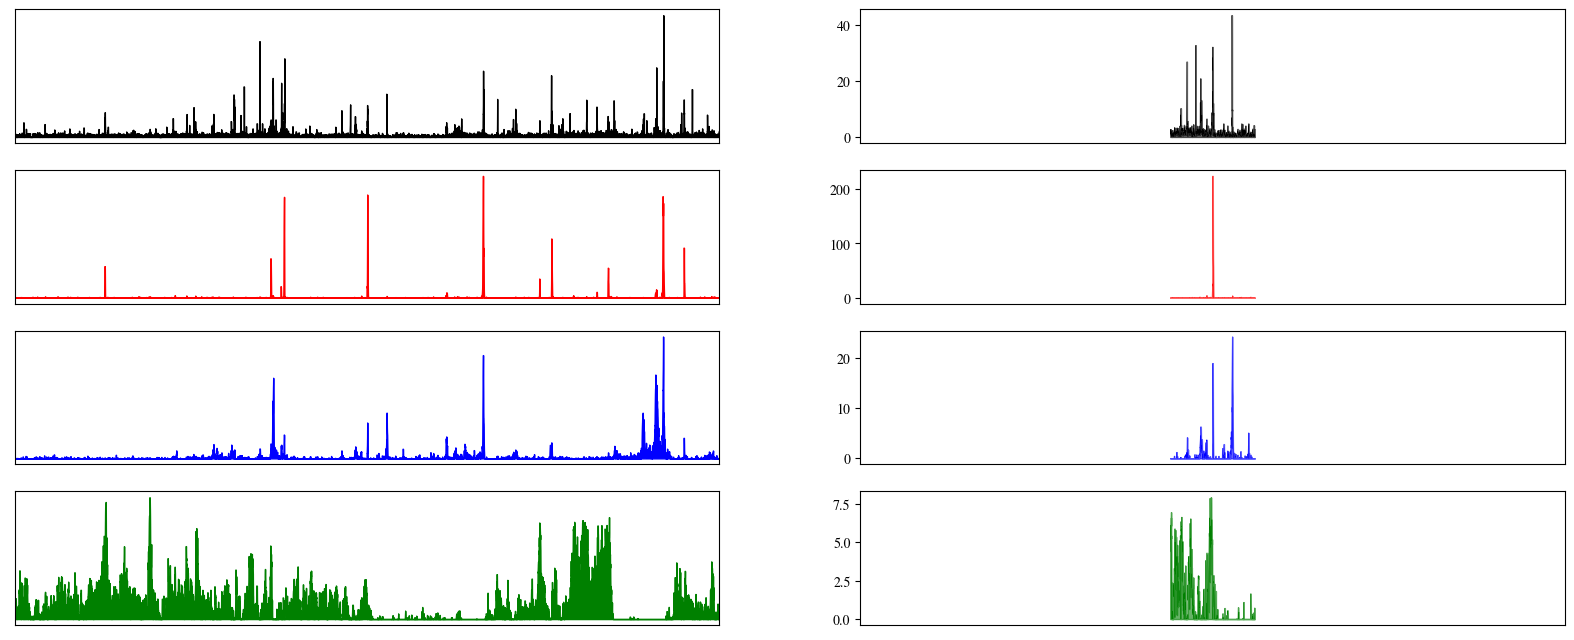

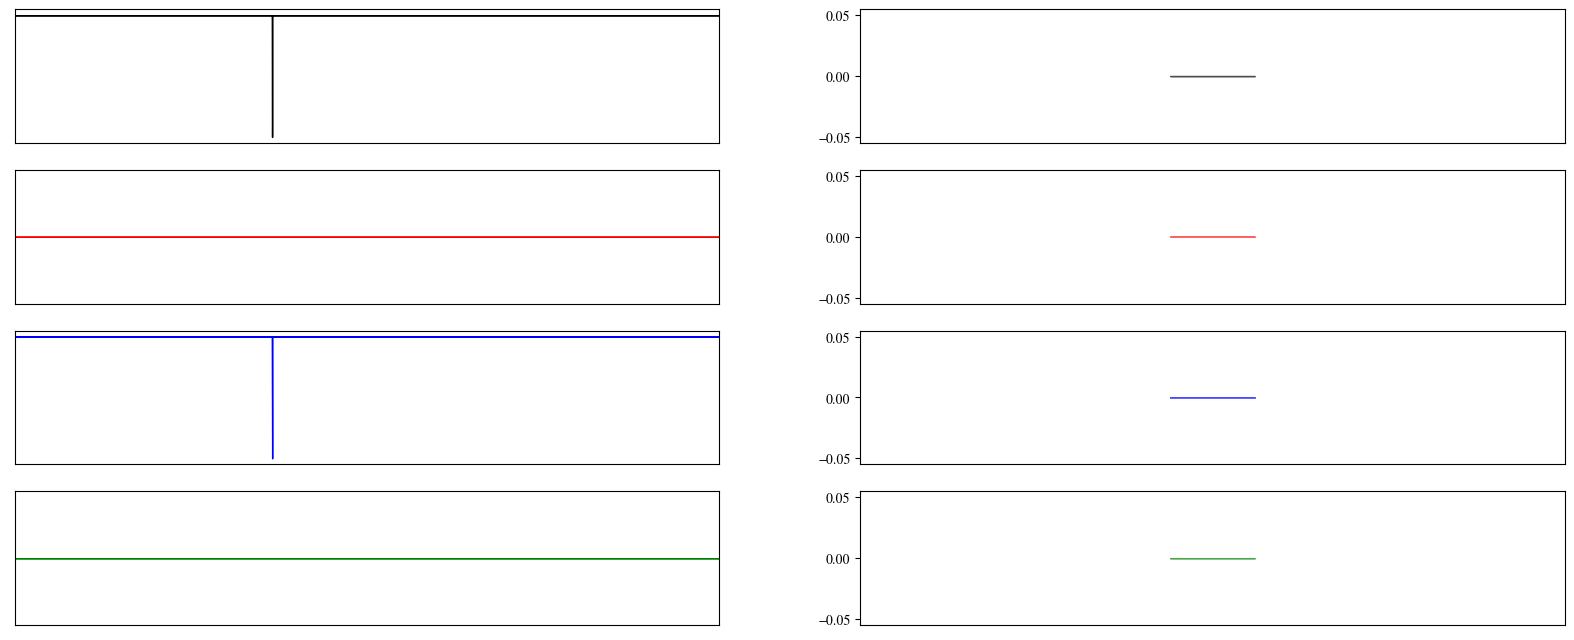

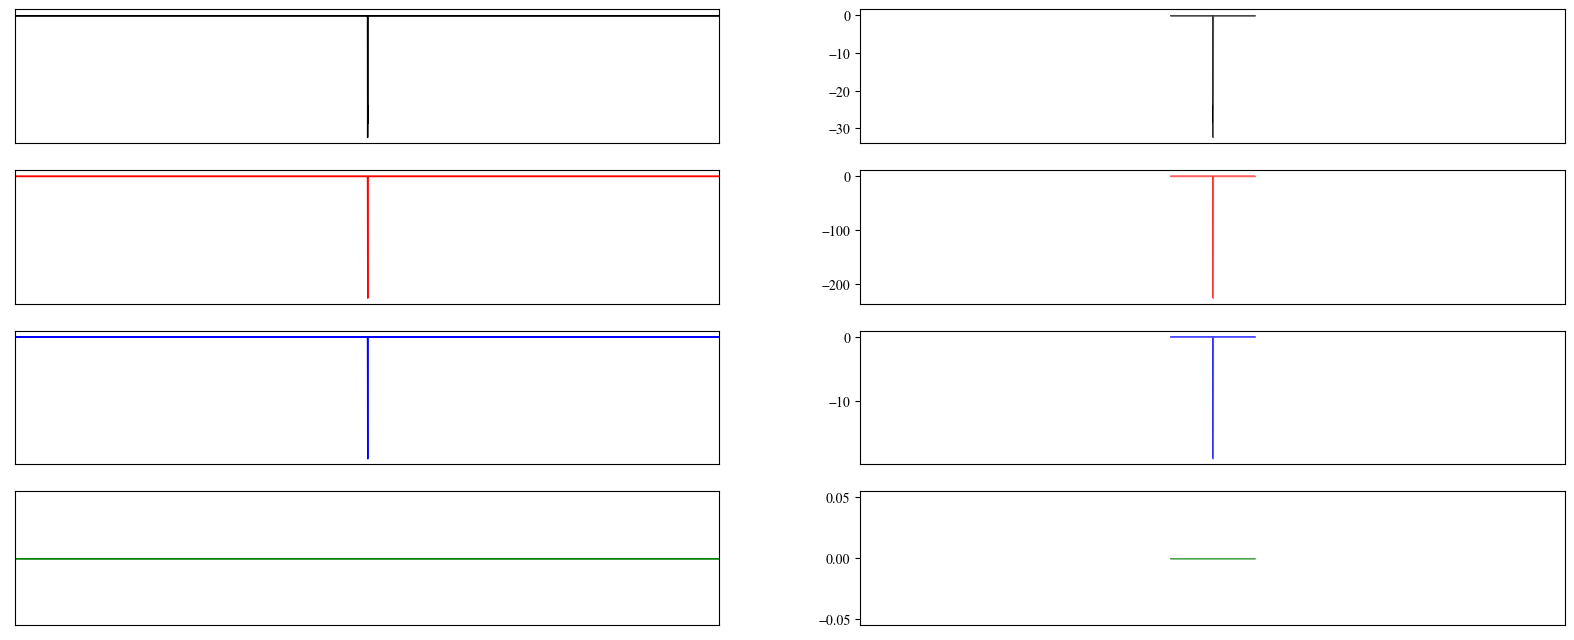

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Nimbus Roman'

track_dict = {0:{"name":"ATAC-seq","function":"Chromatin accessibility","color":"k"},
            1:{"name":"H3K4me3","function":"Promoter","color":"r"},
            2:{"name":"H3K27ac","function":"Enhancer","color":"b"},
            3:{"name":"H3K27me3","function":"Chromatin silencing","color":"g"}}


a = np.load(Path("../inputs/landscape_arrays/test/ENSMUSG00000000085.16_forward.npy"))
b_path = Path("../inputs/perturbed_landscape_arrays/test/")

enhancer_file_list = ["ENSMUSG00000000085.16_EM10E0767043_forward.npy","ENSMUSG00000000085.16_EM10E0767089_forward.npy"]

def visualize_input_array(a,
                     cropped_bins : int = 4400,
                     scaling_factor: float = 1.,
                     track_dict: dict = track_dict):

    """
    Function to visualize an input numpy array.
    """

    fig, axs = plt.subplots(len(track_dict), 2, figsize=(20,8), sharex = True)

    # Plot the scaled arrays
    for j,line in enumerate(a):
        #axs[0][0].set_title(file.name[:-4])
        axs[j][0].plot(np.arange(-len(line)//2,len(line)//2),line*scaling_factor, color=track_dict[j]["color"], label=track_dict[j]["name"], lw=.2)
        axs[j][0].fill_between(np.arange(-len(line)//2,len(line)//2),line*scaling_factor, color=track_dict[j]["color"], alpha=1)
        axs[j][0].set_yticks([]) #([0,int(np.max(line))], [0,int(np.max(line))], fontsize=16)
        #axs[j][0].set_ylim(0,350)
        #axs[j][0].set_ylabel(track_dict[j]["name"])
        #axs[-1][0].set_xlabel("Distance to TSS (kbp)", fontsize= 16)
        axs[-1][0].set_xticks([])#([-5000,0,5000], [-500, 0, 500], fontsize= 16)
        axs[-1][0].set_xlim((-5000,5000))

        axs[j][1].plot(np.arange(-len(line)//2,len(line)//2)[cropped_bins:-cropped_bins],line[cropped_bins:-cropped_bins], color=track_dict[j]["color"], label=track_dict[j]["name"], lw=.2)
        axs[j][1].fill_between(np.arange(-len(line)//2,len(line)//2)[cropped_bins:-cropped_bins],line[cropped_bins:-cropped_bins], color=track_dict[j]["color"], alpha=.6)

    return fig

fig = visualize_input_array(a)
fig.show()
for enhancer_file in enhancer_file_list:
    b = np.load(b_path / enhancer_file)
    fig = visualize_input_array(b-a)
    fig.show()


